In [161]:
# general imports
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as jr
from jax import vmap
from jax.nn import softplus
import numpy as np

from scipy.stats import vonmises
from scipy.special import i0, i1
from scipy.optimize import root_scalar
from numpy.core.numeric import isscalar

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
import setuptools

import PyQt6

import ssm
import pickle
import matplotlib.pyplot as plt

/var/folders/9t/68zflby9385dfmd93cm_b7ph0000gn/T/ipykernel_46556/1760389866.py:13: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric.isscalar.
  from numpy.core.numeric import isscalar


In [4]:
# import functions from gpslds codebase
from data.generate_synthetic_data import generate_synthetic_dynamics

from gpslds.kernels import Linear, SSL
from gpslds.transition import SparseGP
from gpslds.likelihoods import PoissonProcess
from gpslds.initialization import initialize_zs
from gpslds.quadrature import GaussHermiteQuadrature
from gpslds.em import fit_variational_em
from gpslds.utils import get_transformation_for_latents, get_posterior_f_mean, get_posterior_f_var, get_most_likely_state, get_learned_partition

## Data generation

In [5]:
def A_Bessel(kappa): 
    """Computes the ratio of Bessel functions."""
    r = i1(kappa)/i0(kappa)
    return r

def xi_fun_inv(dt):
    """Computes the inverse of the ratio of Bessel functions by root-finding."""
    f = lambda alpha: alpha * A_Bessel(alpha) - dt
    sol = root_scalar(f,bracket=[0.001,50],method='brentq')
    alpha = sol.root
    return alpha

In [26]:
def generate_data(T=5, dt=0.01,N=80, kappa_phi=1, kappa_v=2, kappa_z=15,batch_size=200):

	np.random.seed(42)
	
	t = np.arange(0,T,dt)
	alpha = xi_fun_inv(kappa_z*dt) 

	### create kappa_z depending on environment. If light is off, kappa_z is zero (maximally uninformative)
	kappa_z_array = alpha * np.ones(int(T/dt)) # precision of absolute heading info

	trajectories = np.zeros((batch_size,len(t),N))
	true_HD = np.zeros((batch_size, len(t)))
	HD_obs = np.zeros((batch_size, len(t)))
	AV_obs = np.zeros((batch_size, len(t)))
	
	for batch in range(batch_size):
		### create hidden state trajectory and observation sequence
		phi = np.zeros(int(T/dt)) # latent state
		phi_0 = 0 
		kappa_0 = 10 # initial certainty
		phi[0] = np.random.vonmises(phi_0,kappa_0)
		phi[0] = (phi[0] + np.pi ) 
		dy = np.zeros(int(T/dt))
		for i in range(1,int(T/dt)):
				phi[i] = np.random.normal(phi[i-1],1/np.sqrt(kappa_phi) * np.sqrt(dt)) #True HD observations
				dy[i] = np.random.normal(phi[i]-phi[i-1],1/np.sqrt(kappa_v) * np.sqrt(dt)) #Angular velocity observations
		phi = (phi % (2*np.pi) ) - np.pi # convert true HD to circular coordinates
		mu_z = np.random.vonmises(phi,kappa_z_array) # draw HD observations from Von Mises distribution based on true HD

		phi_0_r = np.linspace(-np.pi,np.pi-(2*np.pi)/N,N)
		alpha = 100

		##### connectivity matrices
		W_rec_even = np.zeros((N,N))
		for i in range(N):
			for j in range(N):
				W_rec_even[i,j] = 2/N * np.cos(phi_0_r[i] - phi_0_r[j])
				
		W_rec_odd = np.zeros((N,N))
		for i in range(N):
			for j in range(N):
				W_rec_odd[i,j] = 2/N * np.sin(phi_0_r[i] - phi_0_r[j])
				
		M_inh = np.zeros((N,N))
		for i in range(N):
			for j in range(N):
				M_inh[i,j] =  (2/N)**2 * np.cos(phi_0_r[i] - phi_0_r[j])

		# set network parameters to match filtering
		alpha_tilde = 0
		alpha = alpha_tilde + 1/2 * kappa_v/kappa_phi * 1/(kappa_phi + kappa_v)
		W = ( (alpha_tilde + 1/(kappa_phi + kappa_v)) * W_rec_even 
			+ (kappa_v/(kappa_v+kappa_phi))*W_rec_odd * dy[0]/dt )
		M =  M_inh

		# init
		r = np.zeros((int(T/dt),N))
		kappa_0 = np.random.uniform(0,15)
		r[0] = kappa_0 * np.cos(phi_0_r - np.random.choice(phi_0_r))

		# run network filter
		for i in range(1,int(T/dt)):
			W =  ( (alpha_tilde + 1/(kappa_phi + kappa_v)) * W_rec_even 
			+ (kappa_v/(kappa_v+kappa_phi))*W_rec_odd * dy[i]/dt )
			r[i] = (r[i-1] 
					- alpha * r[i-1] * dt # decay
					- 1/(kappa_phi+kappa_v) * np.sqrt(np.dot(r[i-1],np.dot(M,r[i-1]))) * r[i-1] * dt # coincidence detector
					+ np.dot(W,r[i-1]) * dt # angular velocity integration
				+ kappa_z_array[i]*np.cos(phi_0_r-mu_z[i])) # absolute heading info (external input)
			
		trajectories[batch, :,:] = r
		true_HD[batch,:] = phi
		HD_obs[batch,:] = mu_z
		AV_obs[batch,:] = dy

	return trajectories, true_HD, HD_obs, AV_obs

In [72]:
def get_mu_kappa(N_HD, r_HD):
    phi_0_HD = jnp.linspace(-jnp.pi,jnp.pi-(2*jnp.pi)/N_HD,N_HD)  # HD preferred angle

    # decode stochastic variables from HD population
    A_cos =  jnp.array([jnp.cos(phi_0_HD),jnp.sin(phi_0_HD)])
    theta = 2/N_HD * jnp.einsum('LN,btN->btL', A_cos, r_HD) # FT in Cartesian domain
    kappa = jnp.sqrt(jnp.sum(theta**2,axis=-1)) #convert to polar coordinates
    mu = jnp.arctan2(theta[...,1],theta[...,0])
    return theta, mu, kappa

In [89]:
def latent_to_fr(theta_t, N, link='exp'):

    phi_0_r = np.linspace(-np.pi,np.pi-(2*np.pi)/N,N)

    C = np.zeros((N,2))
    for i, phi in enumerate(phi_0_r):
        C[i,0] = np.cos(phi)
        C[i,1] = np.sin(phi)

    C = jnp.asarray(C)

    d = np.zeros(C.shape[0])

    a = np.einsum('Nx, xtb->btN' , C, np.transpose(theta_t)) + d 

    if link == 'exp':
        return np.exp(a)
    elif link == 'softplus':
        return softplus(a)
    

In [74]:
def generate_poisson_process(rate_matrix,dt):

    E_spikes = rate_matrix*dt

    spike_raster = np.random.poisson(E_spikes)
    return spike_raster

In [162]:
trajectories, true_HD, HD_obs, AV_obs = generate_data(T=10, dt=0.01, N=36, batch_size=100)

theta_t, mu_t, kappa_t = get_mu_kappa(36, trajectories)

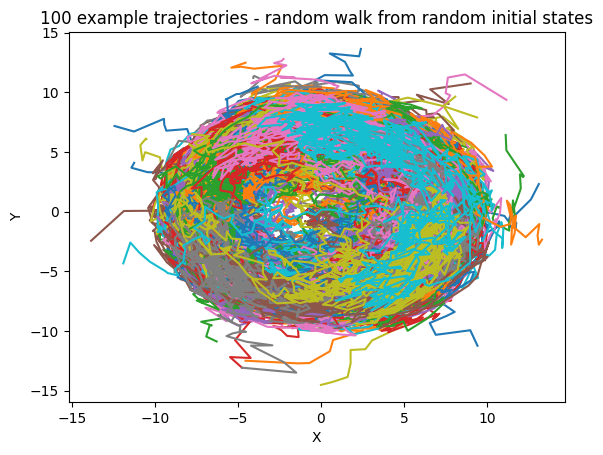

In [164]:
fig = plt.figure()

for i in range(theta_t.shape[0]):
    plt.plot(theta_t[i,:,0], theta_t[i,:,1])

plt.title('100 example trajectories - random walk from random initial states')
plt.xlabel('X')
plt.ylabel('Y')

plt.show()

In [139]:
rate_matrix = latent_to_fr(theta_t, 36, link='softplus')
spike_raster = generate_poisson_process(rate_matrix, 0.01)
spike_raster[spike_raster>1] = 1

In [167]:
%matplotlib qt

fig = plt.figure()

plt.imshow(np.transpose(spike_raster[4,:200,:]))
plt.colorbar()

plt.show()

fig = plt.figure()

plt.imshow(np.transpose(rate_matrix[4,:200,:]))
plt.colorbar()

plt.show()


## Initialize model

In [144]:
latent_dim = 2
n_trials, n_timesteps, n_neurons = spike_raster.shape
spikes = jnp.asarray(spike_raster)
dt = 0.01

N=36
phi_0_r = np.linspace(-np.pi,np.pi-(2*np.pi)/N,N)

# initialize quadrature object and kernel
num_bases = 3
basis_set = lambda x: jnp.array([1., jnp.arctan(x[1]/x[0]), jnp.sqrt(jnp.square(x[0])+jnp.square(x[1]))]) # Basis set for decision boundaries in polar coordinates
gh_quad = GaussHermiteQuadrature(latent_dim, n_quad=6)
linear_kernel = Linear(gh_quad)
kernel = SSL(gh_quad, linear_kernel, basis_set=basis_set)

# initialize inducing points and function
zs_lim, M_per_dim = 4, 4
zs = initialize_zs(latent_dim, zs_lim, M_per_dim)
M = zs.shape[0]
fn = SparseGP(zs, kernel)
# initialize likelihood
t_mask = jnp.ones((n_trials, n_timesteps))
trial_mask = jnp.ones((n_trials, n_timesteps))
likelihood = PoissonProcess(spikes, t_mask, dt, gh_quad, link='softplus')

In [158]:
print(HD_obs.shape)
print(AV_obs.shape)

I_ext_mu = jnp.asarray([np.cos(HD_obs), np.sin(AV_obs)])
neuron_basis = jnp.asarray(np.transpose([np.cos(phi_0_r), np.sin(phi_0_r)]))
kz = 15

I_ext = kz*jnp.einsum('Nl, lbt->Nbt',neuron_basis, I_ext_mu)
input = jnp.concat((I_ext, jnp.expand_dims(AV_obs,axis=0)), axis=0)
input = jnp.transpose(input,(1,2,0))
print(input.shape)

(5, 1000)
(5, 1000)
(5, 1000, 37)


In [159]:
# generate random seeds
key = jr.PRNGKey(1)
key_W, key_fp = jr.split(key, 2)

# intiialize number of linear states and kernel hyperparameters
num_states = 2
W_init = tfd.Normal(0, 1).sample((num_bases, num_states-1), seed=key_W).astype(jnp.float64)
fp_init = tfd.Normal(0, 1).sample((num_states, latent_dim), seed=key_fp).astype(jnp.float64)
tau_init = 0.5
kernel_params_init = {
    "linear_params": [{"fixed_point": fp_init[i]} for i in range(num_states)],
    "log_tau": jnp.log(tau_init),
    "W": W_init
}

# initialize initial conditions for latents from Poisson LDS
x0_init_params = jnp.asarray(theta_t[:,0,:]) # just using initial starting points, don't know if this is the best choice

C = np.zeros((N,2))
for i, phi in enumerate(phi_0_r):
    C[i,0] = np.cos(phi)
    C[i,1] = np.sin(phi)

C = jnp.asarray(C)

d = jnp.zeros(C.shape[0])

# initialize output parameters from Poisson LDS
output_params_init = {'C': C, 'd': d}

In [160]:
key = jr.PRNGKey(0) # for minibatching; doesn't matter here, since we are using batch_size=n_trials

# set number of total vEM iters
n_iters = 1

# set a learning rate schedule
decay, forgetting_rate = 50, -0.9
learning_rates = (decay + jnp.arange(1, 1 + n_iters)) ** (forgetting_rate)

# fit model
result = fit_variational_em(key,
                            latent_dim,
                            dt,
                            fn,
                            likelihood,
                            trial_mask,
                            output_params_init,
                            kernel,
                            kernel_params_init,
                            inputs=input,
                            m0=x0_init_params,
                            mu0=x0_init_params,
                            n_iters=n_iters,
                            n_iters_e=15,
                            n_iters_m=150,
                            learning_rates=learning_rates,
                            batch_size=n_trials)

# collect results
ms, Ss, As, bs, B, q_u_mu, q_u_sigma, output_params, kernel_params, elbos = result

iter: 0, elbo = 1479.5804785003843
